Importing Libraries 

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator #image generator label data based on the dir the image in contained in
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from keras.utils import get_file, image_dataset_from_directory
import pathlib

Loading images using image_dataset_from_directory and setting batch_size at 32

In [2]:
dataset  = image_dataset_from_directory(
    'datasets/chest_xray/chest_xray/',
    color_mode='rgb',
    batch_size = 128,
    image_size=(256,256)
)

Found 5856 files belonging to 3 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-10 10:53:08.466575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-10 10:53:08.466745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Getting the shape of the data and the labels in the class

In [3]:
for data, labels in dataset.take(1):
    print(data.shape)
    print(labels.shape)

2022-07-10 10:53:08.520701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(128, 256, 256, 3)
(128,)


In [4]:
test_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)
train_image_generator = ImageDataGenerator(rescale=1./255)

test_datagen = test_image_generator.flow_from_directory(
    'datasets/chest_xray/',
    target_size=(256,256),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    classes=['test'],
    shuffle=False)
    
val_datagen = val_image_generator.flow_from_directory(
    'datasets/chest_xray/val/',
    target_size=(256,256),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=True)

train_datagen = val_image_generator.flow_from_directory(
    'datasets/chest_xray/train/',
    target_size=(256,256),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=True)

Found 624 images belonging to 1 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


Normalizing and augmenting dataset

In [5]:
dataset_datagen = ImageDataGenerator(
    rotation_range= 0.5,
    width_shift_range= 0.2,
    height_shift_range= 0.5,
    horizontal_flip=True,
    vertical_flip=True,
    rescale= 1./255
)

train_datagen = dataset_datagen.flow_from_directory(
    'datasets/chest_xray/train',
    target_size=(256,256),
    color_mode='grayscale',
    batch_size=128,
    class_mode='binary',
    shuffle=True)


Found 5216 images belonging to 2 classes.


# Setting up the CNN

In [6]:
model = Sequential()
model.add(Conv2D(filters=32, 
                 kernel_size=3, 
                  padding='SAME',
                 activation='relu', 
                 input_shape=(256,256, 1)
                 )
        )
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, 
                 kernel_size=5, 
                 padding='SAME',
                 activation='relu', 
                 
                 # input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
                 )
        )
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, 
                 kernel_size=7, 
                 padding='SAME',
                 activation='relu', 
                 #input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
                 )
        )
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, 
                 kernel_size=9, 
                 padding='SAME',
                 activation='relu', 
                 # input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
                 )
        )
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,
                 activation = 'relu'
))
model.add(Dense(1, 
                activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        100416    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

### Compiling the model based on the binary_crossentropy loss function 

In [7]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

### Calculation of the step_size_train and step_size_valid

In [8]:
STEP_SIZE_TRAIN=train_datagen.n//train_datagen.batch_size
STEP_SIZE_VALID=val_datagen.n//val_datagen.batch_size

### Fitting the model based on the training data 

In [9]:
history = model.fit(
    train_datagen,
    epochs = 15,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=val_datagen,
    validation_steps=STEP_SIZE_VALID,
)

Epoch 1/15


2022-07-10 10:53:12.301984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 63s 2s/step - loss: 0.6988 - accuracy: 0.7400
Epoch 2/15
40/40 [==============================] - 60s 1s/step - loss: 0.4122 - accuracy: 0.7740
Epoch 3/15
40/40 [==============================] - 62s 2s/step - loss: 0.3672 - accuracy: 0.8190
Epoch 4/15
40/40 [==============================] - 69s 2s/step - loss: 0.3563 - accuracy: 0.8278
Epoch 5/15
40/40 [==============================] - 74s 2s/step - loss: 0.3477 - accuracy: 0.8324
Epoch 6/15
40/40 [==============================] - 69s 2s/step - loss: 0.3380 - accuracy: 0.8379
Epoch 7/15
40/40 [==============================] - 72s 2s/step - loss: 0.3276 - accuracy: 0.8434
Epoch 8/15
40/40 [==============================] - 68s 2s/step - loss: 0.3398 - accuracy: 0.8298
Epoch 9/15
40/40 [==============================] - 74s 2s/step - loss: 0.3171 - accuracy: 0.8514
Epoch 10/15
40/40 [==============================] - 66s 2s/step - loss: 0.3179 - accuracy: 0.8426
Epoch 11/15
40/40 [===========

### Evaluating the model based on the images from the val folder

In [10]:
history = model.evaluate(
    val_datagen,
    batch_size = 128,
)

2022-07-10 11:10:39.497573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 749ms/step - loss: 0.5399 - accuracy: 0.8125


In [11]:
print('The testing accuracy is :',history[1]*100, '%')

The testing accuracy is : 81.25 %


### Predicting the probabilities of the images 

In [12]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% normal")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% pnuemonia")
    plt.show()

2022-07-10 11:10:40.424469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 141ms/step


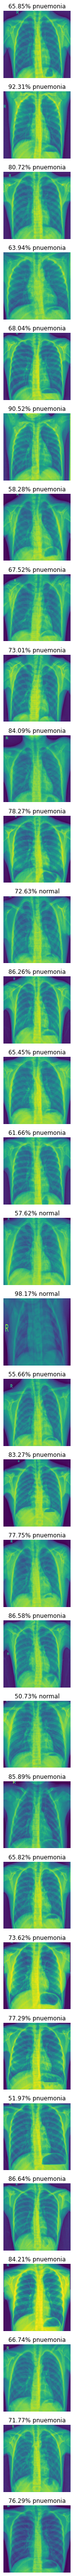

In [13]:
probabilities = model.predict(test_datagen)
probabilities = probabilities.reshape(-1)
probabilities = probabilities.tolist()

sample_testing_images, _ = next(test_datagen)
plotImages(sample_testing_images, probabilities = probabilities)